# Linear Behavior of GOE sampled resonances

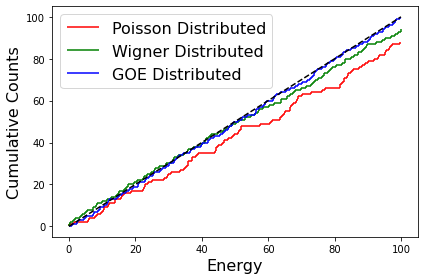

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

def plot_ecdf(X, E0=0.0, color='k', Density:bool=False, label:str=None):
    N = len(X)
    if label is None:
        plt.hlines(0.0, E0, X[0], color)
    else:
        plt.hlines(0.0, E0, X[0], color, label=label)
    if Density:
        [plt.hlines(idx/N, X[idx-1], X[idx], color) for idx in range(1,N)]
        [plt.vlines(x, idx/N, (idx+1)/N, color) for idx, x in enumerate(X)]
    else:
        [plt.hlines(idx, X[idx-1], X[idx], color) for idx in range(1,N)]
        [plt.vlines(x, idx, (idx+1), color) for idx, x in enumerate(X)]

def WigSemicircleCDF(x):
    """
    CDF of Wigner's semicircle law distribution
    """
    return (x/math.pi) * np.sqrt(1.0 - x**2) + np.arcsin(x)/math.pi + 0.5

def SampleEnergies(EB, Freq, w, ensemble='NNE', seed=None, verbose:bool=False):
    """
    ...
    """

    if seed is None:
        seed = np.random.randint(10000)
        if verbose: print(f'Seed: {seed}')
    rng = np.random.default_rng(seed)

    MULTIPLIER = 5
    
    if w == None:       w = 1.0
    if (ensemble in ('GOE','GUE','GSE')) and (w != 1.0):
        raise NotImplementedError(f'Cannot sample "{ensemble}" with Brody parameters')

    if ensemble == 'NNE': # Nearest Neighbor Ensemble
        # Sig = 6.0
        # wig_std = 0.522723200877 # Normalized Wigner distribution standard deviation
        if w == 1.0:
            L_Guess =  Freq * (EB[1] - EB[0]) * MULTIPLIER
            #L_Guess *= 1.5
            #L_Guess += Sig * wig_std * math.sqrt(L_Guess)
            L_Guess = round(L_Guess)

            LS = np.zeros(L_Guess+1, dtype='f8')
            LS[0]  = EB[0] + abs(rng.normal()) * np.sqrt(2/(math.pi * Freq ** 2))
            LS[1:] = np.sqrt((-4/math.pi) * np.log(rng.uniform(size=L_Guess))) / Freq
            E = np.cumsum(LS)
            E = np.array([e for e in E if e <= EB[1]])
        else:
            raise NotImplementedError('No functionality for Brody Distribution yet.')

    elif ensemble == 'GOE': # Gaussian Orthogonal Ensemble
        # Since the eigenvalues do not follow the semicircle distribution
        # exactly, there is a small chance for some values that would never
        # occur with semicircle distribution. Therefore, we make extra
        # eigenvalues and use the ones that are needed. As extra precaution,
        # we select eigenvalues within a margin of the edges of the semicircle
        # distribution.
        margin = 0.1
        N_res_est = Freq*(EB[1]-EB[0])
        N_Tot = round((1 + 2*margin) * N_res_est)

        H = rng.normal(size=(N_Tot,N_Tot)) / math.sqrt(2)
        H += H.T
        H += math.sqrt(2) * np.diag(rng.normal(size=(N_Tot,)) - np.diag(H))
        eigs = np.linalg.eigvals(H) / (2*np.sqrt(N_Tot))
        eigs.sort()
        eigs = eigs[eigs >= -1.0+margin]
        eigs = eigs[eigs <=  1.0-margin]

        E = EB[0] + N_Tot * (WigSemicircleCDF(eigs) - WigSemicircleCDF(-1.0+margin)) / Freq
        E = E[E < EB[1]]

    elif ensemble == 'Poisson':
        NumSamples = rng.poisson(Freq * (EB[1]-EB[0]))
        E = rng.uniform(low=EB[0], high=EB[1], size=(NumSamples,))

    E.sort()
    return E

E_max = 100
EP = SampleEnergies((0,E_max), 1.0, 1.0, ensemble='Poisson')
EN = SampleEnergies((0,E_max), 1.0, 1.0, ensemble='NNE')
EG = SampleEnergies((0,E_max), 1.0, 1.0, ensemble='GOE')

plt.figure()
plt.plot([0,E_max], [0,E_max], '--k')
plot_ecdf(EP, color='red',    label='Poisson Distributed')
plot_ecdf(EN, color='green',   label='Wigner Distributed')
plot_ecdf(EG, color='blue', label='GOE Distributed')
plt.xlabel('Energy', fontsize=16)
plt.ylabel('Cumulative Counts', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()








# Guess Missing Resonance Test

We choose one missing resonance at a random location. Try guessing where it is!

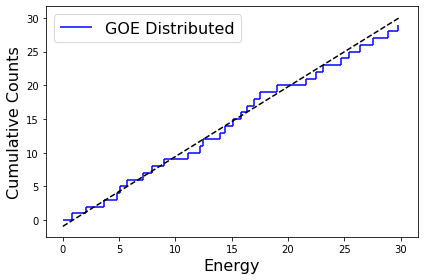

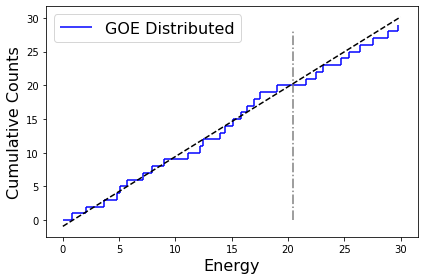

In [24]:
from scipy.optimize import minimize
def DeltaMehta3AB(X, XB:tuple, A:float, B:float):
    N  = len(X)
    H  = np.arange(N+1)
    Y  = A*X+B
    PB = (A*XB[0]+B, A*XB[1]+B-N)
    P1 = Y-H[:-1]
    P2 = Y-H[1:]
    return (np.sum(P1**3 - P2**3) + (PB[1]**3 - PB[0]**3))/(3*A*(XB[1]-XB[0]))
    # return (np.sum(P1**2 + P1*P2 + P2**2) + (A*(XB[1]-XB[0])-N)*(PB[1]**2+PB[1]*PB[0]+PB[0]**2))/(3*A*(XB[1]-XB[0]))
def DeltaMehta3(X, XB:tuple):
    N = len(X)
    A0 = N/(XB[1]-XB[0])
    def func(indvars):  return DeltaMehta3AB(X, XB, *indvars)
    sol  = minimize(func, x0=(A0,0))
    a,b = sol.x
    D3 = DeltaMehta3AB(X, XB, a, b)
    return D3, a, b
def PredictedDM3(n):
    return math.pi**(-2) * (math.log(n) - 0.0687)

E_max = 30
E = SampleEnergies((0,E_max), 1.0, 1.0, ensemble='GOE')
D3, A, B = DeltaMehta3(E, (0, E_max))

idx = np.random.randint(low=5, high=len(E)-5)
EMiss = E[idx]
E = np.concatenate((E[:idx],E[idx+1:]))

EB = np.array((0, E_max))
plt.figure()
plt.plot(EB, A*EB+B, '--k')
plot_ecdf(E, color='blue', label='GOE Distributed')
plt.xlabel('Energy', fontsize=16)
plt.ylabel('Cumulative Counts', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

print('\n'*20)

EB = np.array((0, E_max))
plt.figure()
plt.plot(EB, A*EB+B, '--k')
plot_ecdf(E, color='blue', label='GOE Distributed')
plt.vlines(EMiss, 0, E.size-1, color='gray', linestyles='dashdot')
plt.xlabel('Energy', fontsize=16)
plt.ylabel('Cumulative Counts', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

## Linear fit with missing and false resonances